# Primal Support Vector Machines

## SVM Implementation with squared hinge loss using Newton's method

In [1]:
from sklearn.datasets import make_regression
from sklearn.cross_validation import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy.linalg import norm, cond
from numpy.random import randint
import random
import math
from math import exp
import time 


def loss(y,t): # const
    return pow(max(0,1-(y*t)),2)


def H(C,X,sv): # const
    d = len(X[0])
    summation = np.zeros((d,d))
    for i in sv:
        summation += np.dot(X[i],X[i].T)
    return np.eye(d) + C*summation


def H_inv(C,X,sv): # const
    if cond(H(C,X,sv)) < 1/sys.float_info.epsilon:
        return np.linalg.inv(H(C,X,sv))
    return np.eye(len(X[0]))


def compute_obj(w,C,X,y): # const
    ret = 0.0
    assert len(X)==len(y)
    assert len(X[0])==len(w)
    for i in range(len(X)):
        ret += loss(y[i],np.dot(X[i],w))
    return norm(w)**2 + C*ret


def compute_grad(w,C,X,sv,y): # const
    n=len(sv)
    X[len(X)-1,len(w)-1]
    grad = 2*w.copy()
    for i in range(n):
        assert len(X) > sv[i]
        grad += 2*C*(np.dot(w,X[sv[i]])-y[sv[i]])*X[sv[i]]
    return grad


def my_gradient_descent(X,y,sv,w0=None,initial_step_size=.1,max_iter=1000,C=1,
                        X_test=None, y_test=None,descent_type=''): # const
    tol=10**-4 # scikit learn default
    if w0 == None:
        w0 = np.zeros(len(X[0]))
    if len(X) == 0:
        return 'Error'
    diff = -1
    grad = -1
    
    w = w0
    obj_array = []

    training_error_array = []
    training_error_array.append(score(X, y, w=w))

    testing_error_array = []
    testing_error_array.append(score(X_test, y_test, w=w))
    
    w_array = []
    w_array.append(w.copy())
    
    for i in range(max_iter):
        print 'Iteration',i
        obj=compute_obj(w,C,X,y)
#         print 'obj',obj
        obj_array.append(obj)
        w_p = w
        sv_temp = []
#         print 'sv', sv, sv.shape
#         for i in range(len(sv)):
#             if 1-(y[sv[i]]*(np.dot(w,X[sv[i]]))) > 0:
#                 sv_temp.append(sv[i])
#         sv = np.asarray(sv_temp)
#         print 'sv', sv, sv.shape
        for i in range(len(X)):
            if 1-(y[i]*(np.dot(w,X[i]))) > 0:
                sv_temp.append(i)
        sv = np.asarray(sv_temp)
#         sv = sv[np.where(sv)]
        grad = compute_grad(w,C,X,sv,y)
#         print 'grad',norm(grad)
        gamma = 1.0
        step = - gamma * np.dot(H_inv(C,X,sv), grad)
        if norm(step) < tol:
            break
        while obj < compute_obj(w + step,C,X,y):
            gamma = gamma / 2.0
            step = - gamma * np.dot(H_inv(C,X,sv), grad)
#         print 'step',norm(step)
        if norm(step) < tol:
            break
        w += step
#         print 'w',norm(w)

        w_array.append(w.copy())
        training_error_array.append(score(X, y, w=w))
        testing_error_array.append(score(X_test, y_test, w=w))
        
        if obj*10 < compute_obj(w,C,X,y):
            break
            
        diff = norm(w-w_p)
    if norm(step) > tol:
        print 'Warning: Did not converge.'
    return w, w_array, obj_array, training_error_array, testing_error_array
    
def score(X, y, w): # const
    error = 0.0
    error_comp = 0.0
    for i in range(len(X)):
        prediction = np.sign(np.dot(w,X[i]))
        if prediction == 1 and y[i] == 1:
            error += 1
        elif (prediction == -1 or prediction == 0) and y[i] == -1:
            error += 1
        else:
            error_comp += 1
    return error/len(X)


def my_svm(X_train, y_train,sv,max_iter=None,C=None,X_test=None, y_test=None): # const
    if len(X_train)>1000:
        X_train_sub = X_train[0:len(X_train)/2]
        y_train_sub = y_train[0:len(X_train)/2]
        w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train_sub, y_train_sub, sv, 
                                                max_iter=max_iter, C=C, X_test=X_test, y_test=y_test)
        w, w_array, obj_array, training_error_array, testing_error_array = \
            my_gradient_descent(X_train_sub, y_train_sub,sv,w0=w, max_iter=max_iter,C=C,X_test=X_test, y_test=y_test)
        return w, w_array, obj_array, training_error_array, testing_error_array

    else:
        w0=np.zeros(len(X_train[0]))      
        w, w_array, obj_array, training_error_array, testing_error_array = \
            my_gradient_descent(X_train, y_train,sv,w0=w0, max_iter=max_iter,C=C,X_test=X_test, y_test=y_test)
        return w, w_array, obj_array, training_error_array, testing_error_array


## SVM Usage Example

## Adult Census Dataset

In [2]:
X = []
y = []
with open('adult.data.txt', 'r') as f:
    start = time.time()
    for line in f:
        if line.strip() != '':
            line_split = line.split(',')
            X.append([ float(line_split[0].strip())
                      ,float(line_split[2].strip())
                      ,float(line_split[4].strip())
                      ,float(line_split[10].strip())
                      ,float(line_split[11].strip())
                      ,float(line_split[12].strip())
                     ])
            assert (line_split[-1]).strip() == '<=50K' or (line_split[-1]).strip() == '>50K'
            y.append((line_split[-1]).strip())
    end = time.time()
    print 'Reading File Time:', end - start

start = time.time()

X = np.asarray(X)
y = np.asarray(y)

y[y == '<=50K'] = -1
y[y == '>50K'] = 1

y = y.astype(np.float32, copy=False)

assert len(X)==len(y);assert len(X[y==-1])==len(y[y==-1]);assert len(X[y==1])==len(y[y==1]);

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=20140210)

assert len(X_train)>1;assert len(X_test)>1;assert len(X_train)==len(y_train);assert len(X_test)==len(y_test)
end = time.time()
print 'Process Data Time:', end - start
print

max_iter=1000
C=999.0

# if len(X_train) < 1000:
start = time.time()
sv = np.asarray(range(len(X_train)))
w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train, y_train, sv, 
                                                                          max_iter=max_iter,
                                                                          C=C, X_test=X_test, y_test=y_test)
end = time.time()
print 'Custom w =',w,' test score = ',score(X_test, y_test, w=w)
print 'Custom Time:', end - start
print

start = time.time()
clf = SGDClassifier(loss='squared_hinge', penalty="l2",alpha=1/C, fit_intercept=False)
clf.fit(X_train, y_train); assert clf.intercept_ == 0
end = time.time()
print 'SGDClassifier w = ',(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
print 'Time:', end - start
print
#score(X_test, y_test,w=clf.coef_[0])

start = time.time()
clf = LinearSVC(loss='squared_hinge', penalty="l2",C=C, fit_intercept=False)
clf.fit(X_train, y_train)
end = time.time()
assert clf.intercept_ == 0
print 'LinearSVC w = ',(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
print 'Time:', end - start
print
#score(X_test, y_test, w=clf.coef_[0])


Reading File Time: 0.192080974579
Process Data Time: 0.0444140434265

Iteration 0
Iteration 0
Iteration

/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/mich/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1457: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


 0
Iteration 0
Iteration 0
Iteration 0
Custom w = [ 0.  0.  0.  0.  0.  0.]  test score =  0.755296284925
Custom Time: 13.558973074

SGDClassifier w =  [  9.08520975e+14   6.06534843e+14   2.45845195e+14   2.65504908e+16
   2.14283587e+16   7.84728760e+14]  test score =  0.244703715075
Time: 0.0132308006287

LinearSVC w =  [ -4.74502229e-03  -3.53164288e-06  -2.09910162e-03   9.88263131e-05
   3.43863545e-04  -5.88490789e-03]  test score =  0.780165796745
Time: 3.53345394135



## USPS Digit Image Recognition

In [3]:
X = []
y = []
with open('zip.train', 'r') as f:
    for line in f:
        line_split = line.split()
        y.append(float(line_split[0]))
        X.append(line_split[1:])
X = np.asarray(X)
X = X.astype(np.float32, copy=False)
y = np.asarray(y)

# append constant dimension
# X = np.column_stack((X, np.ones(X.shape[0])))

y[y < 4.5] = -1
y[y >= 4.5] = 1

assert len(X)==len(y);assert len(X[y==-1])==len(y[y==-1]);assert len(X[y==1])==len(y[y==1]);


X_test = []
y_test = []
with open('zip.test', 'r') as f:
    for line in f:
        line_split = line.split()
        y_test.append(float(line_split[0]))
        X_test.append(line_split[1:])
X_test = np.asarray(X_test)
X_test = X_test.astype(np.float32, copy=False)
y_test = np.asarray(y_test)

y_test[y_test < 4.5] = -1
y_test[y_test >= 4.5] = 1

max_iter=100
C=999.0

sample_start = 0
sample_inc = 100
counter=1
time_SVC=[]
time_SGD=[]
while True:
    if counter*sample_inc >= 1000:
        break
    if counter*sample_inc >= len(X):
        X_train = X[sample_start:len(X)-1].copy()
        y_train = y[sample_start:len(X)-1].copy()
    else:
        X_train = X[sample_start:counter*sample_inc].copy()
        y_train = y[sample_start:counter*sample_inc].copy()
        counter += 1
        
    print X_train.shape
    print y_train.shape
    
#     w, w_array, obj_array, training_error_array, testing_error_array = my_svm(X_train_sub, y_train_sub, sv, 
#                                                     max_iter=max_iter, C=C, X_test=X_test, y_test=y_test)
#     print 'Custom w =',norm(w),' test score = ',score(X_test, y_test, w=w)
    
    start = time.time()

    from sklearn import svm
    clf = svm.SVC(C=C, kernel='linear')
    clf.fit(X_train, y_train)
    print 'SVC',' test score = ',clf.score(X_test, y_test)

    end = time.time()
    time_SVC.append(end - start)

    start = time.time()
    
    clf = SGDClassifier(loss='squared_hinge', penalty="l2",alpha=1/C, fit_intercept=False)
    clf.fit(X_train, y_train); assert clf.intercept_ == 0
    print 'SGDClassifier w = ',norm(clf.coef_[0]),' test score = ',clf.score(X_test, y_test)
    #score(X_test, y_test,w=clf.coef_[0])

    end = time.time()
    time_SGD.append(end - start)

    print
    
    if counter*sample_inc >= len(X):
        break

print time_SVC
print time_SGD


(100, 256)
(100,)
SVC  test score =  0.73841554559
SGDClassifier w =  1.41558710788e+14  test score =  0.683109118087

(200, 256)
(200,)
SVC  test score =  0.798704534131
SGDClassifier w =  1.02686252325e+14  test score =  0.796213253612

(300, 256)
(300,)
SVC  test score =  0.804683607374
SGDClassifier w =  8.16961812871e+13  test score =  0.791230692576

(400, 256)
(400,)
SVC  test score =  0.774289985052
SGDClassifier w =  6.7507748544e+13  test score =  0.793223716991

(500, 256)
(500,)
SVC  test score =  0.773293472845
SGDClassifier w =  6.24027013407e+13  test score =  0.806676631789

(600, 256)
(600,)
SVC  test score =  0.776781265571
SGDClassifier w =  5.53109578441e+13  test score =  0.670154459392

(700, 256)
(700,)
SVC  test score =  0.790732436472
SGDClassifier w =  4.9318363592e+13  test score =  0.756352765321

(800, 256)
(800,)
SVC  test score =  0.779272546089
SGDClassifier w =  4.28695857204e+13  test score =  0.800199302441

(900, 256)
(900,)
SVC  test score =  0.7832

/Users/mich/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


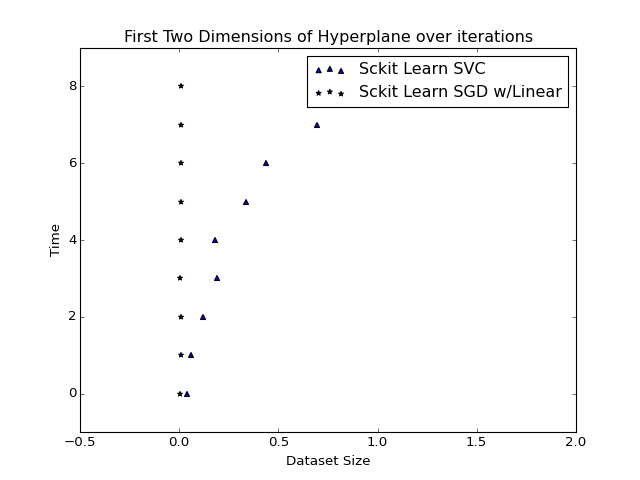

In [4]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

ax.scatter(time_SVC,range(len(time_SVC)),marker='^',label='Sckit Learn SVC')

ax.scatter(time_SGD,range(len(time_SGD)),marker='*',label='Sckit Learn SGD w/Linear')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('First Two Dimensions of Hyperplane over iterations')
plt.ylabel('Time')
plt.xlabel('Dataset Size')